In [1]:
from functions import BECHMARK_FUNCTIONS, FUNCTION_RANGES
import numpy as np
import time
import optuna
from optuna.samplers import RandomSampler, TPESampler
from tqdm.auto import tqdm
import pandas as pd
from ray import tune
from ray.tune.search import BasicVariantGenerator
from ray.tune.search.hyperopt import HyperOptSearch
from hyperopt import fmin, tpe, rand, hp, Trials
from itertools import product
from metagen.framework import Domain
from metagen.logging.metagen_logger import metagen_logger
from metagen.metaheuristics import RandomSearch, TPE
import random
from copy import deepcopy
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from sklearn.datasets import fetch_california_housing, load_breast_cancer, load_iris
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [8]:
ITERATIONS_PER_RUN = 1000

# Data
data = fetch_california_housing()

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()


data.data = scaler_x.fit_transform(data.data)
data.target = scaler_y.fit_transform(data.target.reshape(-1, 1)).ravel()

# Criterion for DecisionTreeRegressor
criterion = ["squared_error", "friedman_mse", "poisson"]

def get_model(model_name, seed, **kwargs):
    if model_name == "elasticnet":
        return ElasticNet(random_state=seed, **kwargs)
    elif model_name == "decision_tree":
        return DecisionTreeRegressor(random_state=seed, **kwargs)
    elif model_name == "sgd":
        return SGDRegressor(random_state=seed, **kwargs)
    elif model_name == "svr":
        return SVR(**kwargs)
    elif model_name == "bayesian_ridge":
        return BayesianRidge(**kwargs)
    else:
        raise ValueError("Unsupported model_name")

def optuna_objective(trial, seed, model_name):
    if model_name == "elasticnet":
        clf = get_model(model_name, seed, 
                        alpha=trial.suggest_float('alpha', 1e-6, np.log(1e5)), 
                        l1_ratio=trial.suggest_float('l1_ratio', 1e-6, 1))
    elif model_name == "decision_tree":
        clf = get_model(model_name, seed, 
                        min_samples_split=trial.suggest_int(f'min_samples', 2, 128), 
                        criterion=criterion[trial.suggest_int(f'criterion', 0, 2)])
    elif model_name == "sgd":
        clf = get_model(model_name, seed, 
                        alpha=trial.suggest_float('alpha', 1e-6, np.log(1e5)),
                        l1_ratio=trial.suggest_float('l1_ratio', 1e-6, 1))
    elif model_name == "svr":
        clf = get_model(model_name, seed, 
                        C=trial.suggest_float('C', 1e-3, 1e3), 
                        epsilon=trial.suggest_float('epsilon', 1e-3, 1))
    elif model_name == "bayesian_ridge":
        clf = get_model(model_name, seed,
                        alpha_1=trial.suggest_float('alpha_1', 1e-6, 1e-1),
                        alpha_2=trial.suggest_float('alpha_2', 1e-6, 1e-1),
                        lambda_1=trial.suggest_float('lambda_1', 1e-6, 1e-1),
                        lambda_2=trial.suggest_float('lambda_2', 1e-6, 1e-1))

    return -cross_val_score(clf, data.data, data.target, cv=3, scoring="neg_mean_absolute_error").mean()

def run_optuna(search_algorithm="random", seed=0, model_name="elasticnet"):
    random.seed(seed)
    np.random.seed(seed)
    start_time = time.time()

    study = optuna.create_study(direction='minimize', 
                                sampler=TPESampler(seed=seed) if search_algorithm == "tpe" else RandomSampler(seed=seed))
    study.optimize(lambda trial: optuna_objective(trial, seed, model_name), 
                   n_trials=ITERATIONS_PER_RUN, show_progress_bar=False)
    best_values = [t.value for t in study.trials if t.value is not None]

    end_time = time.time()

    return {"library": "optuna", "search_algorithm": search_algorithm,
            "best_value": study.best_value, **study.best_params,
            "time": end_time - start_time, "seed": seed, "best_values": deepcopy(best_values)}

def hyperopt_objective(params, seed, model_name):
    clf = get_model(model_name, seed, **params)
    return -cross_val_score(clf, data.data, data.target, cv=3, scoring="neg_mean_absolute_error").mean()

def run_hyperopt(search_algorithm="random", seed=0, model_name="elasticnet"):
    if model_name == "elasticnet" or model_name == "sgd":
        search_space = {"alpha": hp.uniform('alpha', 1e-6, np.log(1e5)),
                        "l1_ratio": hp.uniform('l1_ratio', 1e-6, 1)}
    elif model_name == "decision_tree":
        search_space = {"min_samples_split": hp.choice('min_samples_split', list(range(2, 129))),
                        "criterion": hp.choice('criterion', criterion)}
    elif model_name == "svr":
        search_space = {"C": hp.uniform('C', 1e-3, 1e3),
                        "epsilon": hp.uniform('epsilon', 1e-3, 1)}
    elif model_name == "bayesian_ridge":
        search_space = {
            "alpha_1": hp.uniform('alpha_1', 1e-6, 1e-1),
            "alpha_2": hp.uniform('alpha_2', 1e-6, 1e-1),
            "lambda_1": hp.uniform('lambda_1', 1e-6, 1e-1),
            "lambda_2": hp.uniform('lambda_2', 1e-6, 1e-1)
        }

    random.seed(seed)
    np.random.seed(seed)

    trials = Trials()
    start_time = time.time()
    best = fmin(
        fn=lambda params: hyperopt_objective(params, seed, model_name),
        space=search_space,
        algo=tpe.suggest if search_algorithm == "tpe" else rand.suggest,
        max_evals=ITERATIONS_PER_RUN,
        trials=trials,
        show_progressbar=False,
        rstate=np.random.default_rng(seed)
    )
    end_time = time.time()

    best_loss = min(trials.losses())

    return {"library": "hyperopt", "search_algorithm": search_algorithm, 
            "best_value": best_loss, **best,
            "time": end_time - start_time, "seed": seed, "best_values": deepcopy(trials.losses())}

def metagen_objective(solution, seed, model_name):
    clf = get_model(model_name, seed, **solution)
    return -cross_val_score(clf, data.data, data.target, cv=3, scoring="neg_mean_absolute_error").mean()

def run_metagen(search_algorithm="random", seed=0, model_name="elasticnet"):
    random.seed(seed)
    np.random.seed(seed)

    metagen_logger.setLevel("ERROR")

    domain = Domain()

    if model_name == "elasticnet" or model_name == "sgd":
        domain.define_real("alpha", 1e-6, np.log(1e5))
        domain.define_real("l1_ratio", 1e-6, 1)
    elif model_name == "decision_tree":
        domain.define_integer("min_samples_split", 2, 128)
        domain.define_integer("criterion", 0, 2)
    elif model_name == "svr":
        domain.define_real("C", 1e-3, 1e3)
        domain.define_real("epsilon", 1e-3, 1)
    elif model_name == "bayesian_ridge":
        domain.define_real("alpha_1", 1e-6, 1e-1)
        domain.define_real("alpha_2", 1e-6, 1e-1)
        domain.define_real("lambda_1", 1e-6, 1e-1)
        domain.define_real("lambda_2", 1e-6, 1e-1)

    if search_algorithm == "tpe":
        search = TPE(domain, lambda solution: metagen_objective(solution, seed, model_name), 
                     population_size=ITERATIONS_PER_RUN // 10, 
                     max_iterations=ITERATIONS_PER_RUN // 10)
    else:
        search = RandomSearch(domain, lambda solution: metagen_objective(solution, seed, model_name), 
                              population_size=ITERATIONS_PER_RUN // 10, 
                              max_iterations=ITERATIONS_PER_RUN // 10)

    start_time = time.time()
    best_solution = search.run()
    end_time = time.time()

    return {"library": "metagen", "search_algorithm": search_algorithm, 
            "best_value": best_solution.get_fitness(), **best_solution,
            "time": end_time - start_time, "seed": seed, 
            "best_values": search.best_solution_fitnesses}

def run_baseline(search_algorithm=None, seed=0, model_name="elasticnet"):
    start_time = time.time()
    clf = get_model(model_name, seed)
    best_value = -cross_val_score(clf, data.data, data.target, scoring="neg_mean_absolute_error", cv=3).mean()
    end_time = time.time()

    return {"library": "baseline", "search_algorithm": search_algorithm, 
            "best_value": best_value, "time": end_time - start_time, 
            "seed": seed, "best_values": []}

def run_multiple_seeds(run_func, search_algorithm="random", num_seeds=10, model_name="elasticnet"):
    results = []
    for seed in range(num_seeds):
        result = run_func(search_algorithm, seed, model_name)
        results.append(result)
    return results


In [ ]:
NUM_SEEDS = 10

all_results = []

model_name = "sgd"

for library, search_algorithm in tqdm(list(product([run_metagen], ["random", "tpe"])), desc="Overall Progress"): #run_baseline, run_optuna, run_hyperopt,
    results = run_multiple_seeds(library, search_algorithm, NUM_SEEDS, model_name)
    all_results.extend(results)

    df = pd.DataFrame(all_results)

    df.to_csv(f"{model_name}_results.csv", index=False)

# for library, search_algorithm in tqdm(list(product([run_baseline, run_optuna, run_hyperopt, run_metagen], ["random", "tpe"])), desc="Overall Progress"): #run_baseline, run_optuna, run_hyperopt,
#     results = run_multiple_seeds(library, search_algorithm, NUM_SEEDS, model_name)
#     all_results.extend(results)
#
#     df = pd.DataFrame(all_results)
#
#     df.to_csv(f"{model_name}_results.csv", index=False)

Overall Progress:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
# df_dt = pd.read_csv("decision_tree_results.csv")
# df_dt["model"] = "dt"

df_sgd = pd.read_csv("sgd_results.csv")
df_sgd["model"] = "sgd"

#df_sgd_metagen = pd.read_csv("sgd_results_metagen.csv")
#df_sgd["model"] = "sgd"

# df_bayesian = pd.read_csv("bayesian_ridge_results.csv")
# df_bayesian["model"] = "bayesian"
#
# df_elasticnet = pd.read_csv("elasticnet_results.csv")
# df_elasticnet["model"] = "elasticnet"
#
# df = pd.concat([df_dt, df_elasticnet, df_sgd]).reset_index(drop=True) #df_sgd
#
# df["best_values"] = df.best_values.apply(eval)
#
# df.loc[df.best_values.apply(len) == 0, "library"] = "baseline"


In [32]:
def average_arrays(arrays):

    if len(arrays.values[0]) == 0:
        return []
    
    averaged_values = np.mean(np.stack(arrays.values), axis=0)

    best_trial_evolution = np.minimum.accumulate(averaged_values)

    return best_trial_evolution

def calculate_convergence_rate(best_values):
    
    return sum([(best_values[i+1] - best_values[i])*100 / best_values[i] for i in range(len(best_values) - 1)]) / (len(best_values) -1)

averaged_arrays = df.groupby([ "library", "search_algorithm", "model"])["best_values"].apply(average_arrays)

convergence_rate = averaged_arrays.apply(calculate_convergence_rate)

In [33]:
grouped_metrics = df.groupby([ "library", "search_algorithm", "model"]).mean(numeric_only=True)
grouped_metrics["best_values"] = averaged_arrays
grouped_metrics["convergence_rate"] = convergence_rate

In [34]:
grouped_metrics[["best_value", "time", "convergence_rate"]].reset_index().pivot(index=["library", "model"], columns="search_algorithm", values=["best_value", "time", "convergence_rate"]).round(3)#.to_latex("results_ml.tex")

best_value            time          convergence_rate  \
search_algorithm        random    tpe   random      tpe           random   
library  model                                                             
baseline dt              0.324  0.324    0.000    0.000           -0.000   
         elasticnet      0.692  0.692    0.000    0.000           -0.000   
         sgd             0.130  0.130    0.036    0.036           -0.000   
hyperopt dt              0.279  0.279  217.480  211.980           -0.023   
         elasticnet      0.554  0.550   22.109  101.538           -0.015   
         sgd             0.139  0.130   20.440   24.708           -0.003   
metagen  dt              0.279  0.297  196.763  108.828           -0.067   
         elasticnet      0.554  0.554   31.342   20.418           -0.098   
         sgd             0.132  0.130  193.025  197.793           -0.192   
optuna   dt              0.280  0.280  109.335   41.116           -0.035   
         elasticnet      0.553  0.550   22.036  211.901           -0.015   
         sgd             0.138  0.130   20.859   30.295           -0.002   

                            
search_algorithm       tpe  
library  model              
baseline dt         -0.000  
         elasticnet -0.000  
         sgd        -0.000  
hyperopt dt         -0.038  
         elasticnet -0.041  
         sgd        -0.017  
metagen  dt         -0.009  
         elasticnet -0.114  
         sgd         0.000  
optuna   dt         -0.067  
         elasticnet -0.039  
         sgd        -0.021

In [10]:
grouped_metrics[grouped_metrics.index.get_level_values(1)=="tpe"]#.to_latex("results_tpe.tex")

,,best_value,best_max_depth,time,seed,best_values,convergence_rate
library,search_algorithm,,,,,,
baseline,tpe,0.324131,32.0,0.000000,4.5,[],-0.000000
hyperopt,tpe,0.279004,1.0,211.979803,4.5,"[0.4127143339312502, 0.4127143339312502, 0.412...",-0.037699
metagen,tpe,0.296587,9.7,108.828293,4.5,"[0.29921035386184364, 0.2990880497255666, 0.29...",-0.008868
optuna,tpe,0.280350,1.0,41.116452,4.5,"[0.39930757262931305, 0.37432943518154216, 0.3...",-0.066681


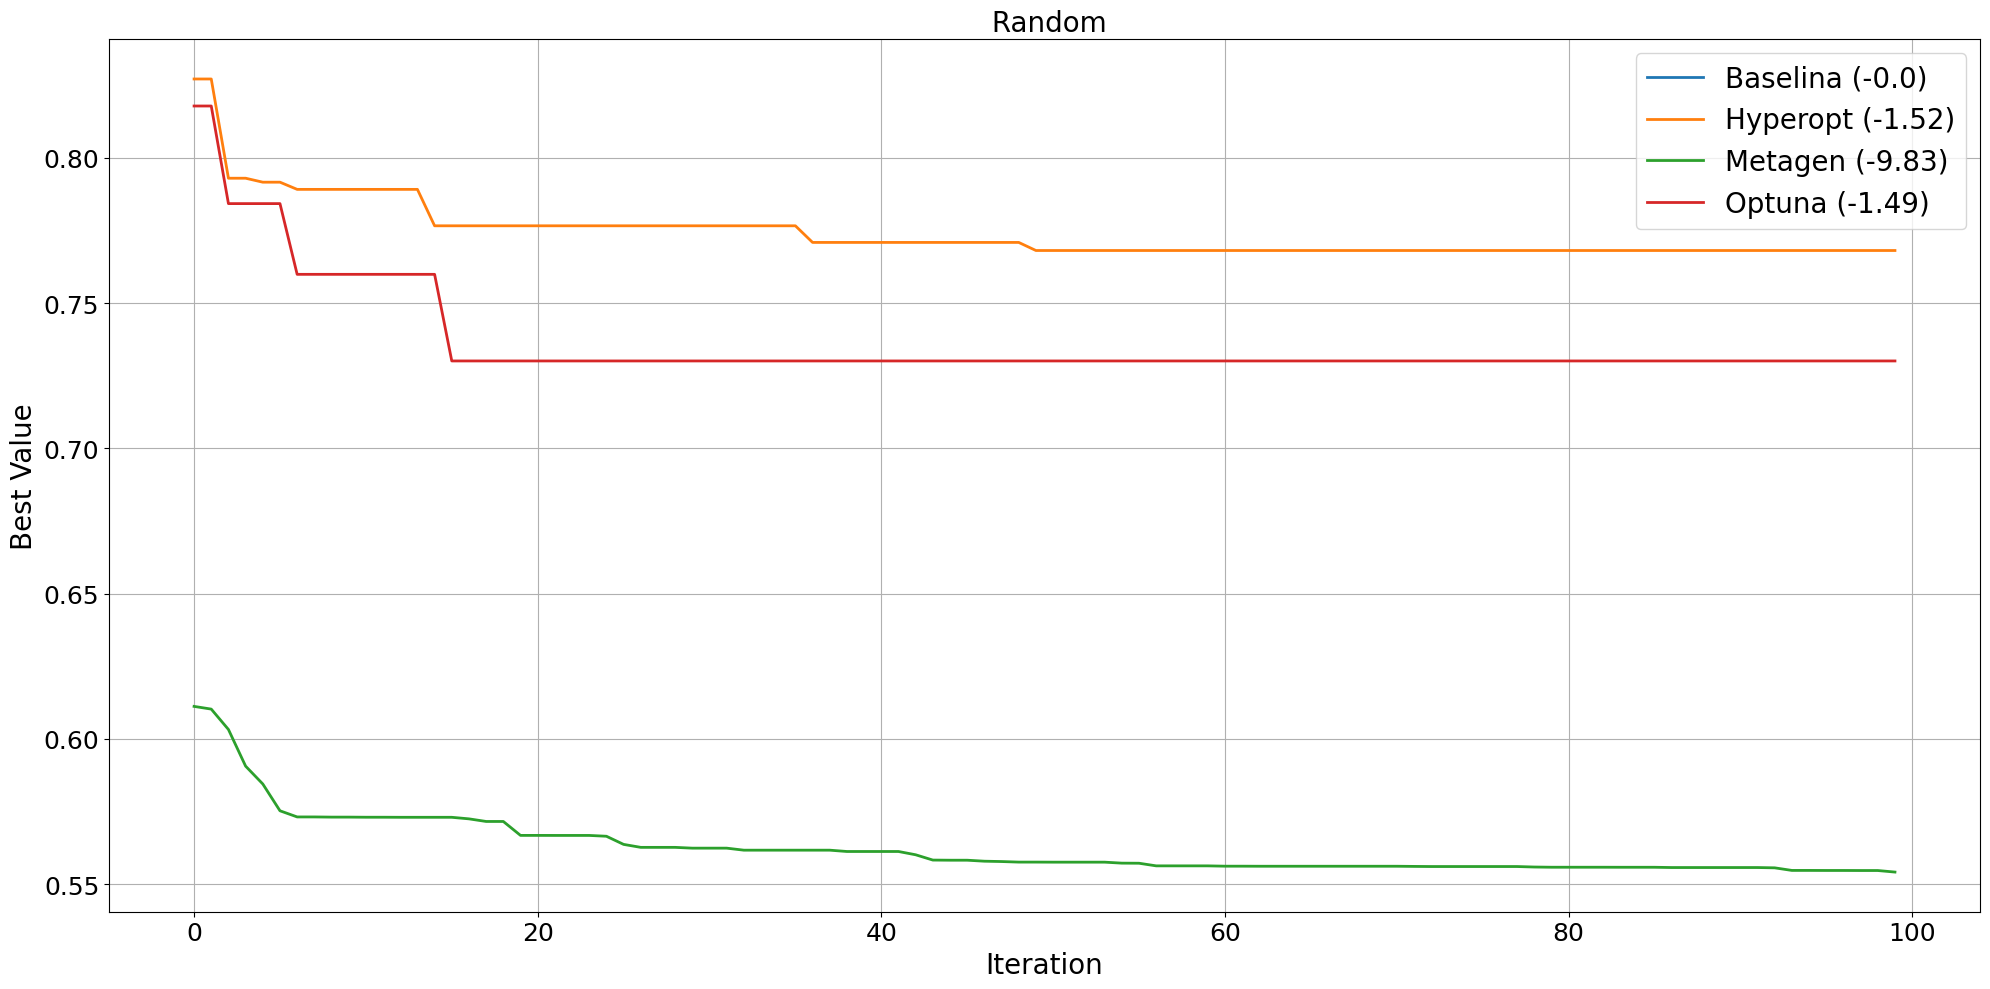

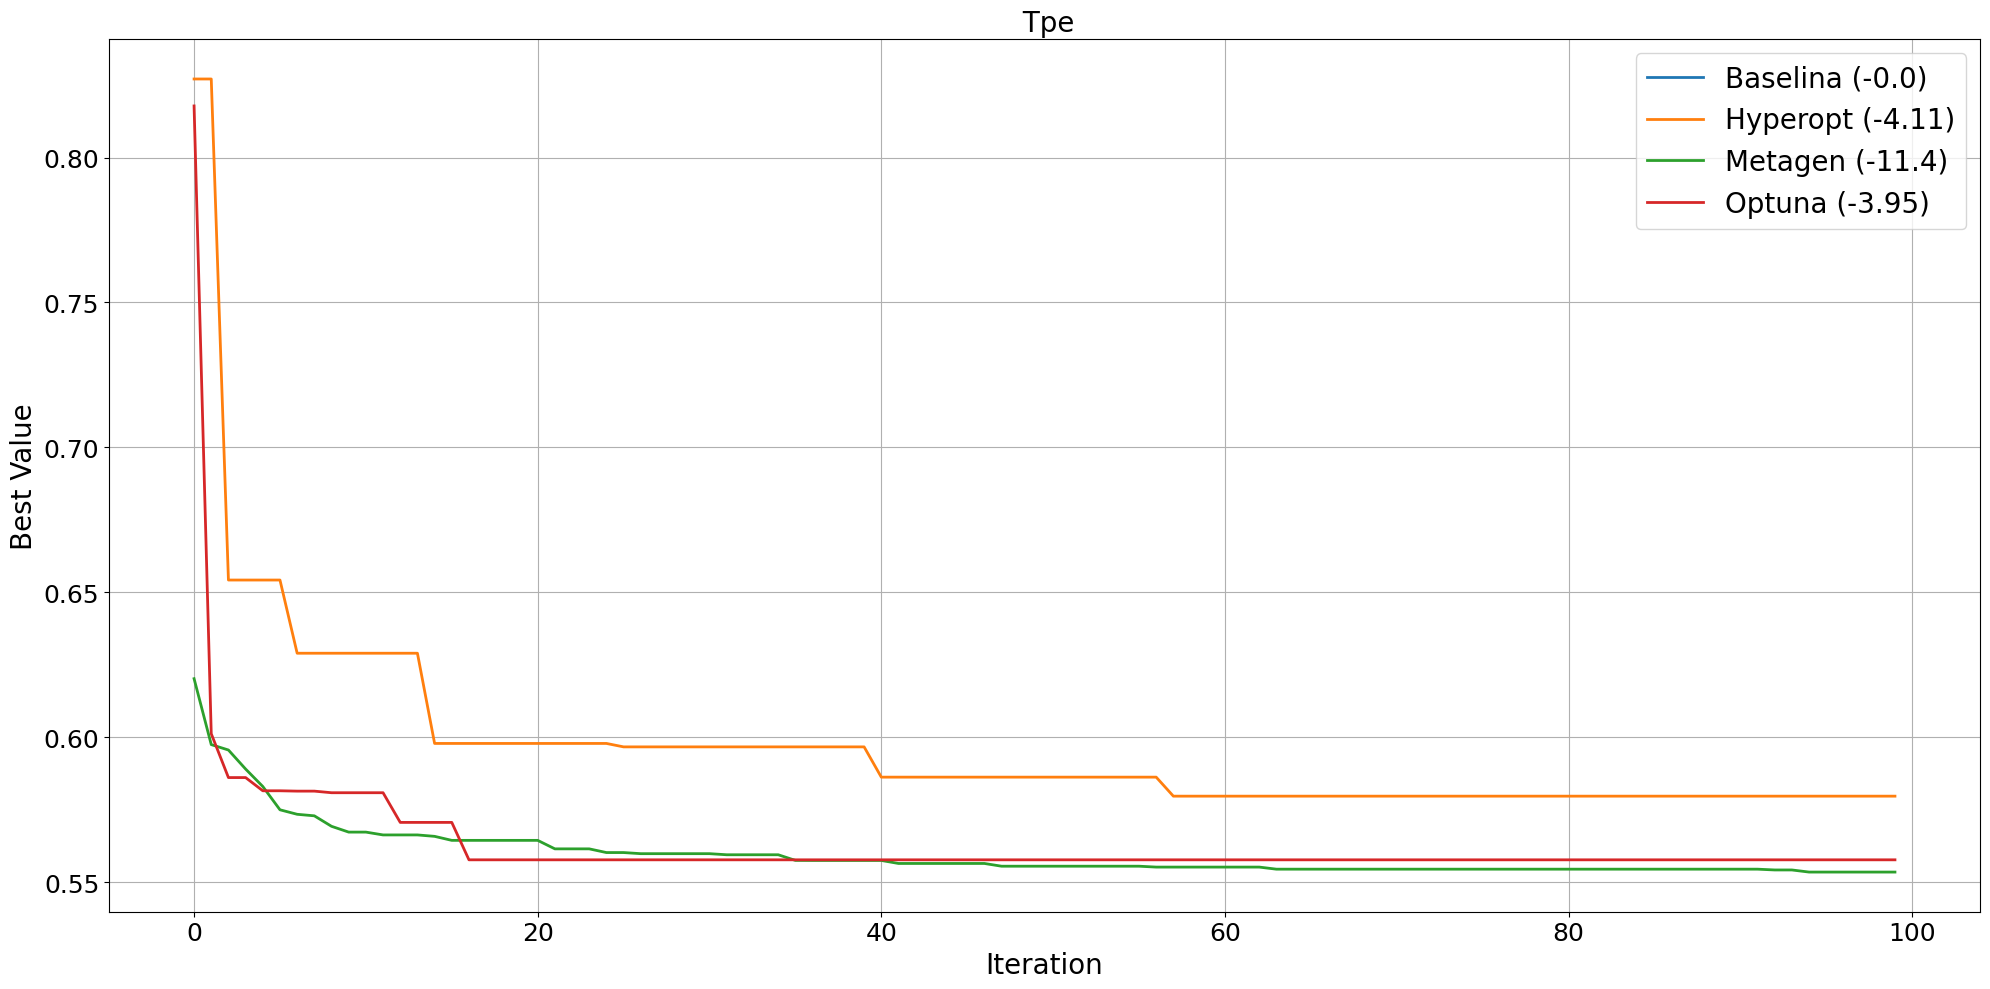

In [10]:
import matplotlib.pyplot as plt

def reescale_evolution(arr):
    n = len(arr) // 10
    
    min_values = []
    
    for i in range(n):
        chunk = arr[i*10:(i+1)*10]
        min_values.append(np.min(chunk))
    
    if len(arr) % 10 != 0:
        min_values.append(np.min(arr[n*10:]))
    
    return np.array(min_values)

for search_algorithm in ["random", "tpe"]:

    filtered_metrics = grouped_metrics[(grouped_metrics.index.get_level_values(1)==search_algorithm)]

    plt.figure(figsize=(20, 10), tight_layout=True)
    plt.title(f' {search_algorithm.capitalize()}', fontdict={'size': 20})
    for (library, search_algorithm), row in filtered_metrics.iterrows():

        best_values = row['best_values'] if library == "metagen" else reescale_evolution(row['best_values'])


        plt.plot(best_values, label=f'{library.capitalize()} ({round(row["convergence_rate"]*100, 2)})', linewidth=2)
        plt.xlabel('Iteration', fontdict={'size': 20})
        plt.xticks(fontsize=18)
        plt.ylabel('Best Value', fontdict={'size': 20})
        plt.yticks(fontsize=18)

    plt.grid()
    plt.legend(fontsize=20)
    plt.show()

In [84]:
np.roll(row['best_values']).shape

(1000,)

In [79]:
moving_average(row['best_values'], 10)

array([5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875305,
       5.45875305, 5.45875305, 5.45875305, 5.45875305, 5.45875

In [76]:
row[['best_values']].rolling(10).min()

DataError: No numeric types to aggregate

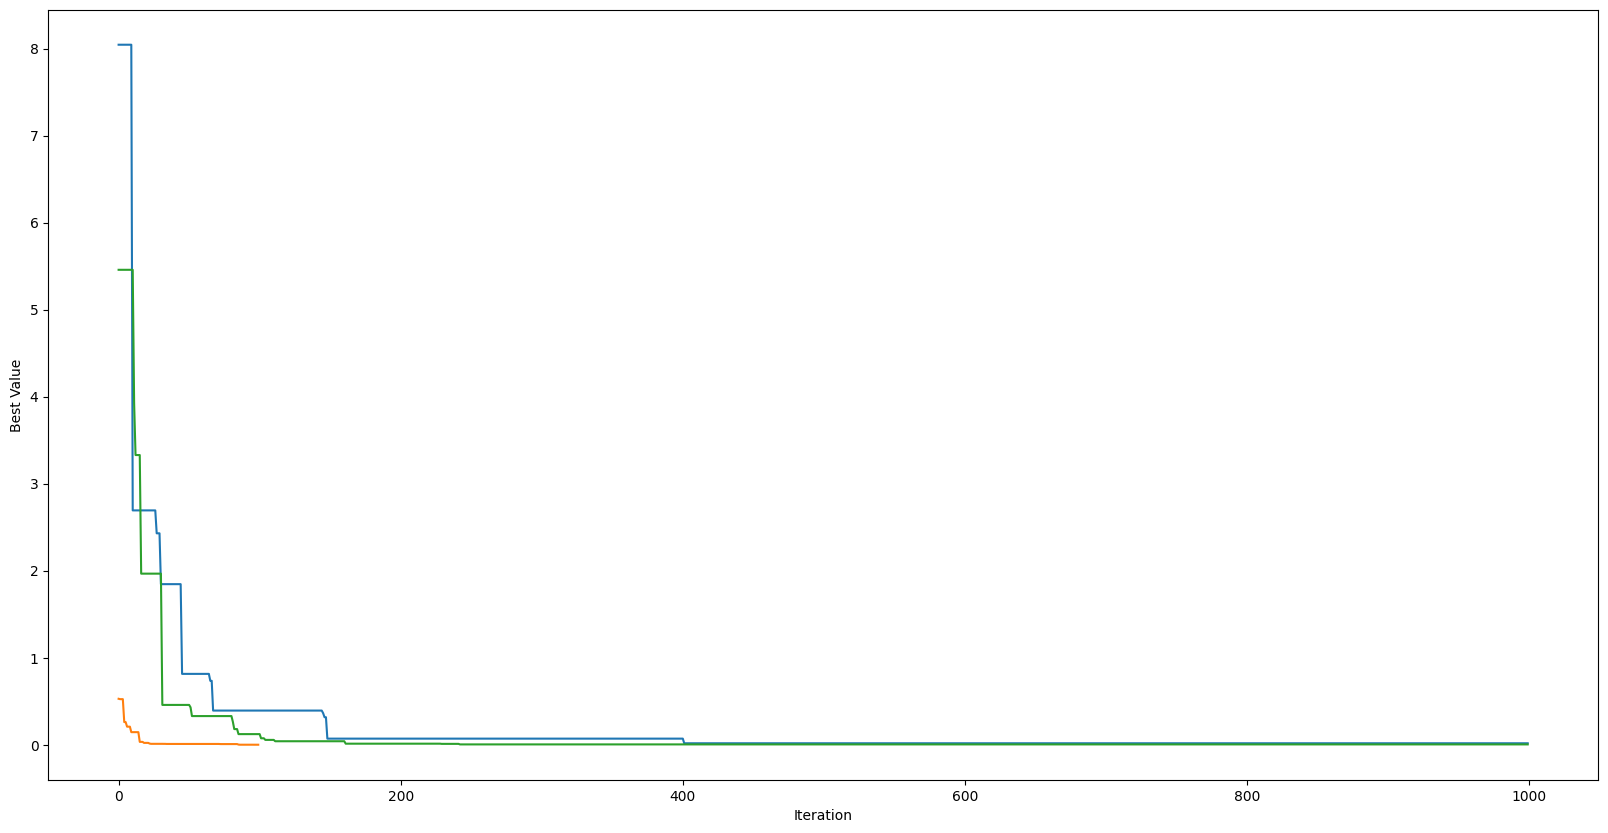

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
# Iterate over each group in the grouped_metrics dataframe
for (function_name, library, search_algorithm), row in grouped_metrics[grouped_metrics.index.get_level_values(2)=="tpe"].iterrows():
    plt.plot(row['best_values'], label=f'{library} - {search_algorithm}')
    plt.xlabel('Iteration')
    plt.ylabel('Best Value')
plt.show()